In [ ]:
!pip install kaggle

In [ ]:
!mkdir ~/.kaggle
cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
cp kaggle.json ~/.kaggle/


In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download kwentar/blur-dataset

blur-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
!sudo apt install unzip

Reading package lists... Done
Building dependency tree       
Reading state information... Done
unzip is already the newest version (6.0-21ubuntu1.1).
0 upgraded, 0 newly installed, 0 to remove and 39 not upgraded.


In [ ]:
!unzip blur-dataset.zip

**Augmentasi**

In [ ]:
import cv2
import numpy as np
from tqdm import tqdm
import os

In [ ]:
np.__file__

'/usr/local/lib/python3.7/dist-packages/numpy/__init__.py'

In [ ]:
os.makedirs('data/gaussian_blurred')
src_directory = 'data/sharp'
images = os.listdir(src_directory)
dst_dir = "data/gaussian_blurred"

In [ ]:
for i, image in (tqdm(enumerate(images), total=len(images))):
    img = cv2.imread(f"{src_directory}/{images[i]}")
    blur =cv2.GaussianBlur(img, (31, 31), 0)
    cv2.imwrite(f"{dst_dir}/{images[i]}", blur)

100%|██████████| 350/350 [01:23<00:00,  4.17it/s]


In [ ]:
import numpy as np
import os
import matplotlib.pyplot as plt
import glob
import cv2
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import time
import argparse
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import transforms
from torchvision.utils import save_image
from sklearn.model_selection import train_test_split

In [ ]:
parser = argparse.ArgumentParser()
# parser.add_argument('-f')
parser.add_argument('-e')
args = vars(parser.parse_args())


usage: ipykernel_launcher.py [-h] [-e E] [--epochs EPOCHS]
ipykernel_launcher.py: error: unrecognized arguments: -f /root/.local/share/jupyter/runtime/kernel-b0c00a38-95f9-49db-a2fb-eac55631f2e2.json


SystemExit: ignored

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2890: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [ ]:
def save_decoded_image(img, name):
    img = img.view(img.size(0), 3, 224, 224)
    save_image(img, name)

In [ ]:
image_dir = 'outputs/saved_images'
os.makedirs(image_dir, exist_ok=True)
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
print(device)
batch_size = 2

cuda:0


In [ ]:
g_blur = os.listdir('data/gaussian_blurred')
sharp = os.listdir('data/sharp')
x_blur = sorted(g_blur)
y_sharp = sorted(sharp)

In [ ]:
(x_train, x_val, y_train, y_val) = train_test_split(x_blur, y_sharp, test_size=0.25)

In [ ]:
transform = transforms.Compose([
    transforms.ToPILImage(), 
    transforms.Resize((224, 244)), 
    transforms.ToTensor(),
])

In [ ]:
class DeblurDataset(Dataset):
    def __init__ (self, blur_path, sharp_path=None, transforms=None):
        self.x = blur_path
        self.y = sharp_path
        self.transforms = transforms
    def __len__(self):
        return (len(self.x))
    def __getitem__(self, i):
        blur_image = cv2.imread(f"data/gaussian_blurred/{self.x[i]}")
        if self.transforms:
            blur_image = self.transforms(blur_image)
        if self.y is not None:
            sharp_image = cv2.imread(f"data/sharp/{self.y[i]}")
            sharp_image = self.transforms(sharp_image)
            return(blur_image, sharp_image)
        else:
            return blur_image

In [ ]:
train = DeblurDataset(x_train, y_train, transform)
val = DeblurDataset(x_train, y_train, transform)

train_loader = DataLoader(train, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val, batch_size=batch_size, shuffle=False)

In [ ]:
class SRCNN(nn.Module):
    def __init__(self):
        super(SRCNN, self).__init__()

        self.conv1 = nn.Conv2d(3, 64, kernel_size=9, padding=2)
        self.conv2 = nn.Conv2d(64, 32, kernel_size=1, padding=2)
        self.conv3 = nn.Conv2d(32, 3, kernel_size=5, padding=2)
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.conv3(x)
        return x

In [ ]:
model = SRCNN().to(device)
print(model)

Model(
  (conv1): Conv2d(3, 64, kernel_size=(9, 9), stride=(1, 1), padding=(2, 2))
  (conv2): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1), padding=(2, 2))
  (conv3): Conv2d(32, 3, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
)


In [ ]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau( 
        optimizer,
        mode='min',
        patience=5,
        factor=0.5,
        verbose=True
    )

In [ ]:
def fit(model, dataloader, epoch):
    model.train()
    r_loss = 0
    loss_list = []
    for i, data in tqdm(enumerate(dataloader), total=int(len(train)/dataloader.batch_size)):
        blur_img = data[0].to(device)
        sharp_img = data[1].to(device)
        optimizer.zero_grad()
        outputs = model(blur_img)
        loss = criterion(outputs, sharp_img)
        loss.backward()
        optimizer.step()
        r_loss += loss.item()
        loss_list.append(loss.item())
    train_loss = r_loss / len(dataloader.dataset)
    print(f"Training Loss: {train_loss:.5f}")
    return train_loss

In [ ]:
def validate(model, dataloader, epoch):
    model.eval()
    running_loss = 0.0
    with torch.no_grad():
        for i, data in tqdm(enumerate(dataloader), total=int(len(val)/dataloader.batch_size)):
            blur_image = data[0]
            sharp_image = data[1]
            blur_image = blur_image.to(device)
            sharp_image = sharp_image.to(device)
            outputs = model(blur_image)
            loss = criterion(outputs, sharp_image)
            running_loss += loss.item()
            # if epoch == 0 and i == int((len(val)/dataloader.batch_size)-1):
            #     save_decoded_image(sharp_image.cpu().data, name=f"../outputs/saved_images/sharp{epoch}.jpg")
            #     save_decoded_image(blur_image.cpu().data, name=f"../outputs/saved_images/blur{epoch}.jpg")
            # if i == int((len(val)/dataloader.batch_size)-1):
            #     save_decoded_image(outputs.cpu().data, name=f"../outputs/saved_images/val_deblurred{epoch}.jpg")
        val_loss = running_loss/len(dataloader.dataset)
        print(f"Val Loss: {val_loss:.5f}")
        
        return val_loss

In [ ]:
train_loss  = []
val_loss = []
n_epoch = 10
start = time.time()
for epoch in range(n_epoch):
    print(f"Epoch {epoch+1} of {n_epoch}")
    train_epoch_loss = fit(model, train_loader, epoch)
    val_epoch_loss = validate(model, val_loader, epoch)
    train_loss.append(train_epoch_loss)
    val_loss.append(val_epoch_loss)
    scheduler.step(val_epoch_loss)
end = time.time()
print(f"Took {((end-start)/60):.3f} minutes to train")

Epoch 1 of 10


100%|██████████| 131/131 [00:41<00:00,  3.14it/s]


Training Loss: 0.00111


100%|██████████| 131/131 [00:37<00:00,  3.53it/s]


Val Loss: 0.00077
Epoch 2 of 10


100%|██████████| 131/131 [00:39<00:00,  3.30it/s]


Training Loss: 0.00072


100%|██████████| 131/131 [00:35<00:00,  3.70it/s]


Val Loss: 0.00065
Epoch 3 of 10


100%|██████████| 131/131 [00:39<00:00,  3.33it/s]


Training Loss: 0.00066


100%|██████████| 131/131 [00:35<00:00,  3.72it/s]


Val Loss: 0.00222
Epoch 4 of 10


100%|██████████| 131/131 [00:39<00:00,  3.34it/s]


Training Loss: 0.00088


100%|██████████| 131/131 [00:36<00:00,  3.60it/s]


Val Loss: 0.00065
Epoch 5 of 10


100%|██████████| 131/131 [00:40<00:00,  3.24it/s]


Training Loss: 0.00057


100%|██████████| 131/131 [00:36<00:00,  3.55it/s]


Val Loss: 0.00053
Epoch 6 of 10


100%|██████████| 131/131 [00:40<00:00,  3.22it/s]


Training Loss: 0.00084


100%|██████████| 131/131 [00:36<00:00,  3.56it/s]


Val Loss: 0.00060
Epoch 7 of 10


100%|██████████| 131/131 [00:40<00:00,  3.24it/s]


Training Loss: 0.00057


100%|██████████| 131/131 [00:35<00:00,  3.65it/s]


Val Loss: 0.00049
Epoch 8 of 10


100%|██████████| 131/131 [00:39<00:00,  3.34it/s]


Training Loss: 0.00049


100%|██████████| 131/131 [00:35<00:00,  3.73it/s]


Val Loss: 0.00048
Epoch 9 of 10


100%|██████████| 131/131 [00:38<00:00,  3.38it/s]


Training Loss: 0.00050


100%|██████████| 131/131 [00:35<00:00,  3.71it/s]


Val Loss: 0.00040
Epoch 10 of 10


100%|██████████| 131/131 [00:38<00:00,  3.40it/s]


Training Loss: 0.00048


100%|██████████| 131/131 [00:35<00:00,  3.69it/s]

Val Loss: 0.00043
Took 12.631 minutes to train


In [ ]:
ntl = np.array(train_loss)
ntl[3]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  """Entry point for launching an IPython kernel.


array([0.0010840837865488475,
       list([0.004993738140910864, 0.0014401383232325315, 0.0032913079485297203, 0.0013579499209299684, 0.0022926856763660908, 0.0021149655804038048, 0.0022889613173902035, 0.0010845179203897715, 0.0020147589966654778, 0.0018011436332017183, 0.0021769104059785604, 0.0016681364504620433, 0.002174459397792816, 0.0031669405288994312, 0.0015653815353289247, 0.002050207694992423, 0.0014279545284807682, 0.0030476204119622707, 0.0016175138298422098, 0.0014889017911627889, 0.0028190987650305033, 0.0016079242341220379, 0.0011007350403815508, 0.0018317208159714937, 0.0012651474680751562, 0.0017705864738672972, 0.001547446590848267, 0.0016220841789618134, 0.0018339157104492188, 0.0018340770620852709, 0.0014425243716686964, 0.0036503502633422613, 0.0011242638574913144, 0.0023946736473590136, 0.0034234304912388325, 0.0011599586578086019, 0.0017747491365298629, 0.0015004343586042523, 0.0010820417664945126, 0.0014546029269695282, 0.0013380724703893065, 0.0012058686697855

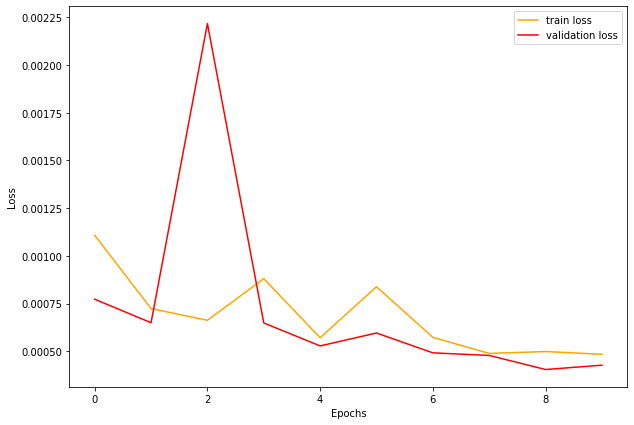

Saving model...


In [ ]:
plt.figure(figsize=(10, 7))
plt.plot(train_loss, color='orange', label='train loss')
plt.plot(val_loss, color='red', label='validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig('outputs/loss.png')
plt.show()
# save the model to disk
print('Saving model...')
torch.save(model.state_dict(), 'outputs/model.pth')